# Malmo Project Few-Shot Learning

Guide: https://huggingface.co/blog/setfit

Requires Python 3.7+

`pip install notebook seaborn pandas datasets setfit sentence-transformers torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116`

In [58]:
import pandas as pd
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer
import torch

In [59]:
# checking for gpu
torch.cuda.is_available()

True

In [69]:
# reading csv files train and test
label_names = {0: "Open chest", 
               1: "Break plant",
               2: "Go to animal",
               3: "Jump in water", 
               4: "Sit next to campfire",
               5: "Play music",
               6: "Go through fence",
               7: "Go inside door",
               8: "Speak to bot"}

dtypes = {"text": str, "label": "int8"}
train_df = pd.read_csv("train.csv", dtype=dtypes)
test_df = pd.read_csv("test.csv", dtype=dtypes)

sample = train_df.sample(5)
sample["task_name"] = sample["label"].map(label_names)
sample

,text,label,task_name
39,Go swimming,3,Jump in water
62,Break into that house,7,Go inside door
12,Go to item from nature,1,Break plant
31,Run towards the,2,Go to animal
13,Reach the horse,2,Go to animal


In [61]:
# loading pretrained model as guide
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
model

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


SetFitModel()

In [62]:
# loading own dataset instead of the one in the guide
data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset("csv", data_files=data_files)
dataset

Using custom data configuration default-66180350609bf2a7


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Angel/.cache/huggingface/datasets/csv/default-66180350609bf2a7/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 71
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 29
    })
})

In [63]:
# building trainer as guide shows
trainer = SetFitTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss_class=CosineSimilarityLoss,
    batch_size=4,
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    num_epochs=1 # Number of epochs to use for contrastive learning
)

In [64]:
# training and getting metrics as shows on guide(just accuracy, I guess)
trainer.train()
metrics = trainer.evaluate()
metrics

***** Running training *****
  Num examples = 2840
  Num epochs = 1
  Total optimization steps = 710
  Total train batch size = 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/710 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.9655172413793104}

In [65]:
# Test/New Instance Results
df = pd.read_csv("test.csv")
instances = df["text"].to_list()
df["pred"] = model(instances)
df["prob"] = torch.max(model.predict_proba(instances), axis=1).values
df

,text,label,pred,prob
0,Get me item from storage,0,0,0.934751
1,Open that storage and get me something,0,0,0.935103
2,Get me diamonds from that chest,0,0,0.908047
3,Go to plant in the world,1,1,0.941686
4,Smell something on grass,1,1,0.923816
5,Sniff plant,1,1,0.948277
6,Go to horse,2,2,0.983018
7,Run towards that pig,2,2,0.982936
8,Arrive at the animal,2,2,0.982892
9,Go to,2,2,0.981972


Note how that last input text has very low confidence compared to the others

In [70]:
# Getting valid rows for evaluation / dropping -1 labels
df = df[df.label != -1]

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df["label"], df["pred"])

Accuracy: 1.0


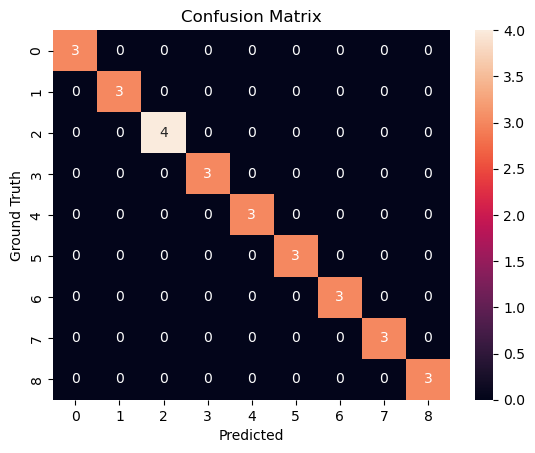

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Accuracy: {len(df['label']==df['pred']) / len(df)}")
# Just plotting for easier read
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted');ax.set_ylabel('Ground Truth'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names);

In [73]:
# Saving model
trainer.model.save_pretrained("malmoTextClassifier")